# EDA for Text Metrics Queries

# Four text metrics we should compute for title/description:
1) Title Uniqueness (computed previously, used now to create title neutrality)

2) Sentiment (+/-), using Valence Aware Dictionary and sEntiment Reasoner (VADER). Disclude values of 0.00 from sentiment analysis because those values are 0.00 due to having words outside the VADER lexicon (possibly another language)

3) Readability (Automated readability index)

4) Length (separate word count & character count)

In [ ]:
import pandas as pd

### Import cleaned and prepared dataset
df = pd.read_csv('https://raw.githubusercontent.com/cacress/CSC442/refs/heads/rithik_eda/datasets/rithik_eda_dataset.csv')

In [ ]:
### Add a simple neutrality measure that is extracted from sentiment scores.
### This will aid in regression analysis, since it is a closeness measure to 0 rather than in one of two opposite directions.
df['title_neutrality'] = 1 - df['title_sentiment'].abs()
df['description_neutrality'] = 1 - df['description_sentiment'].abs()

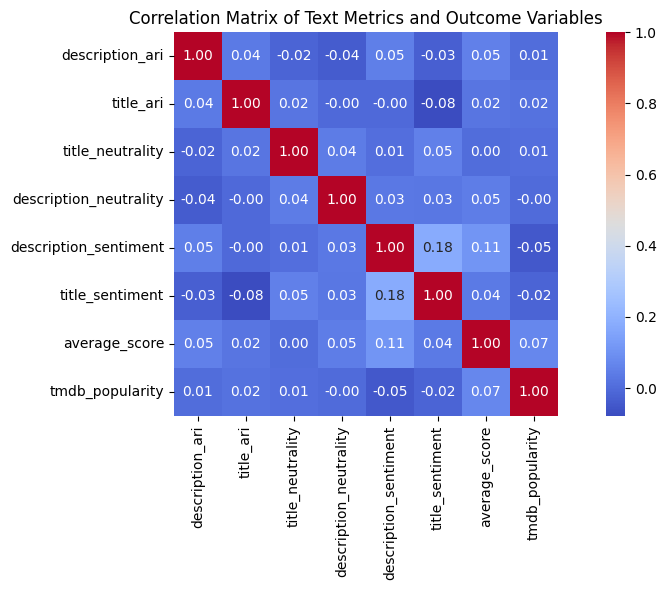

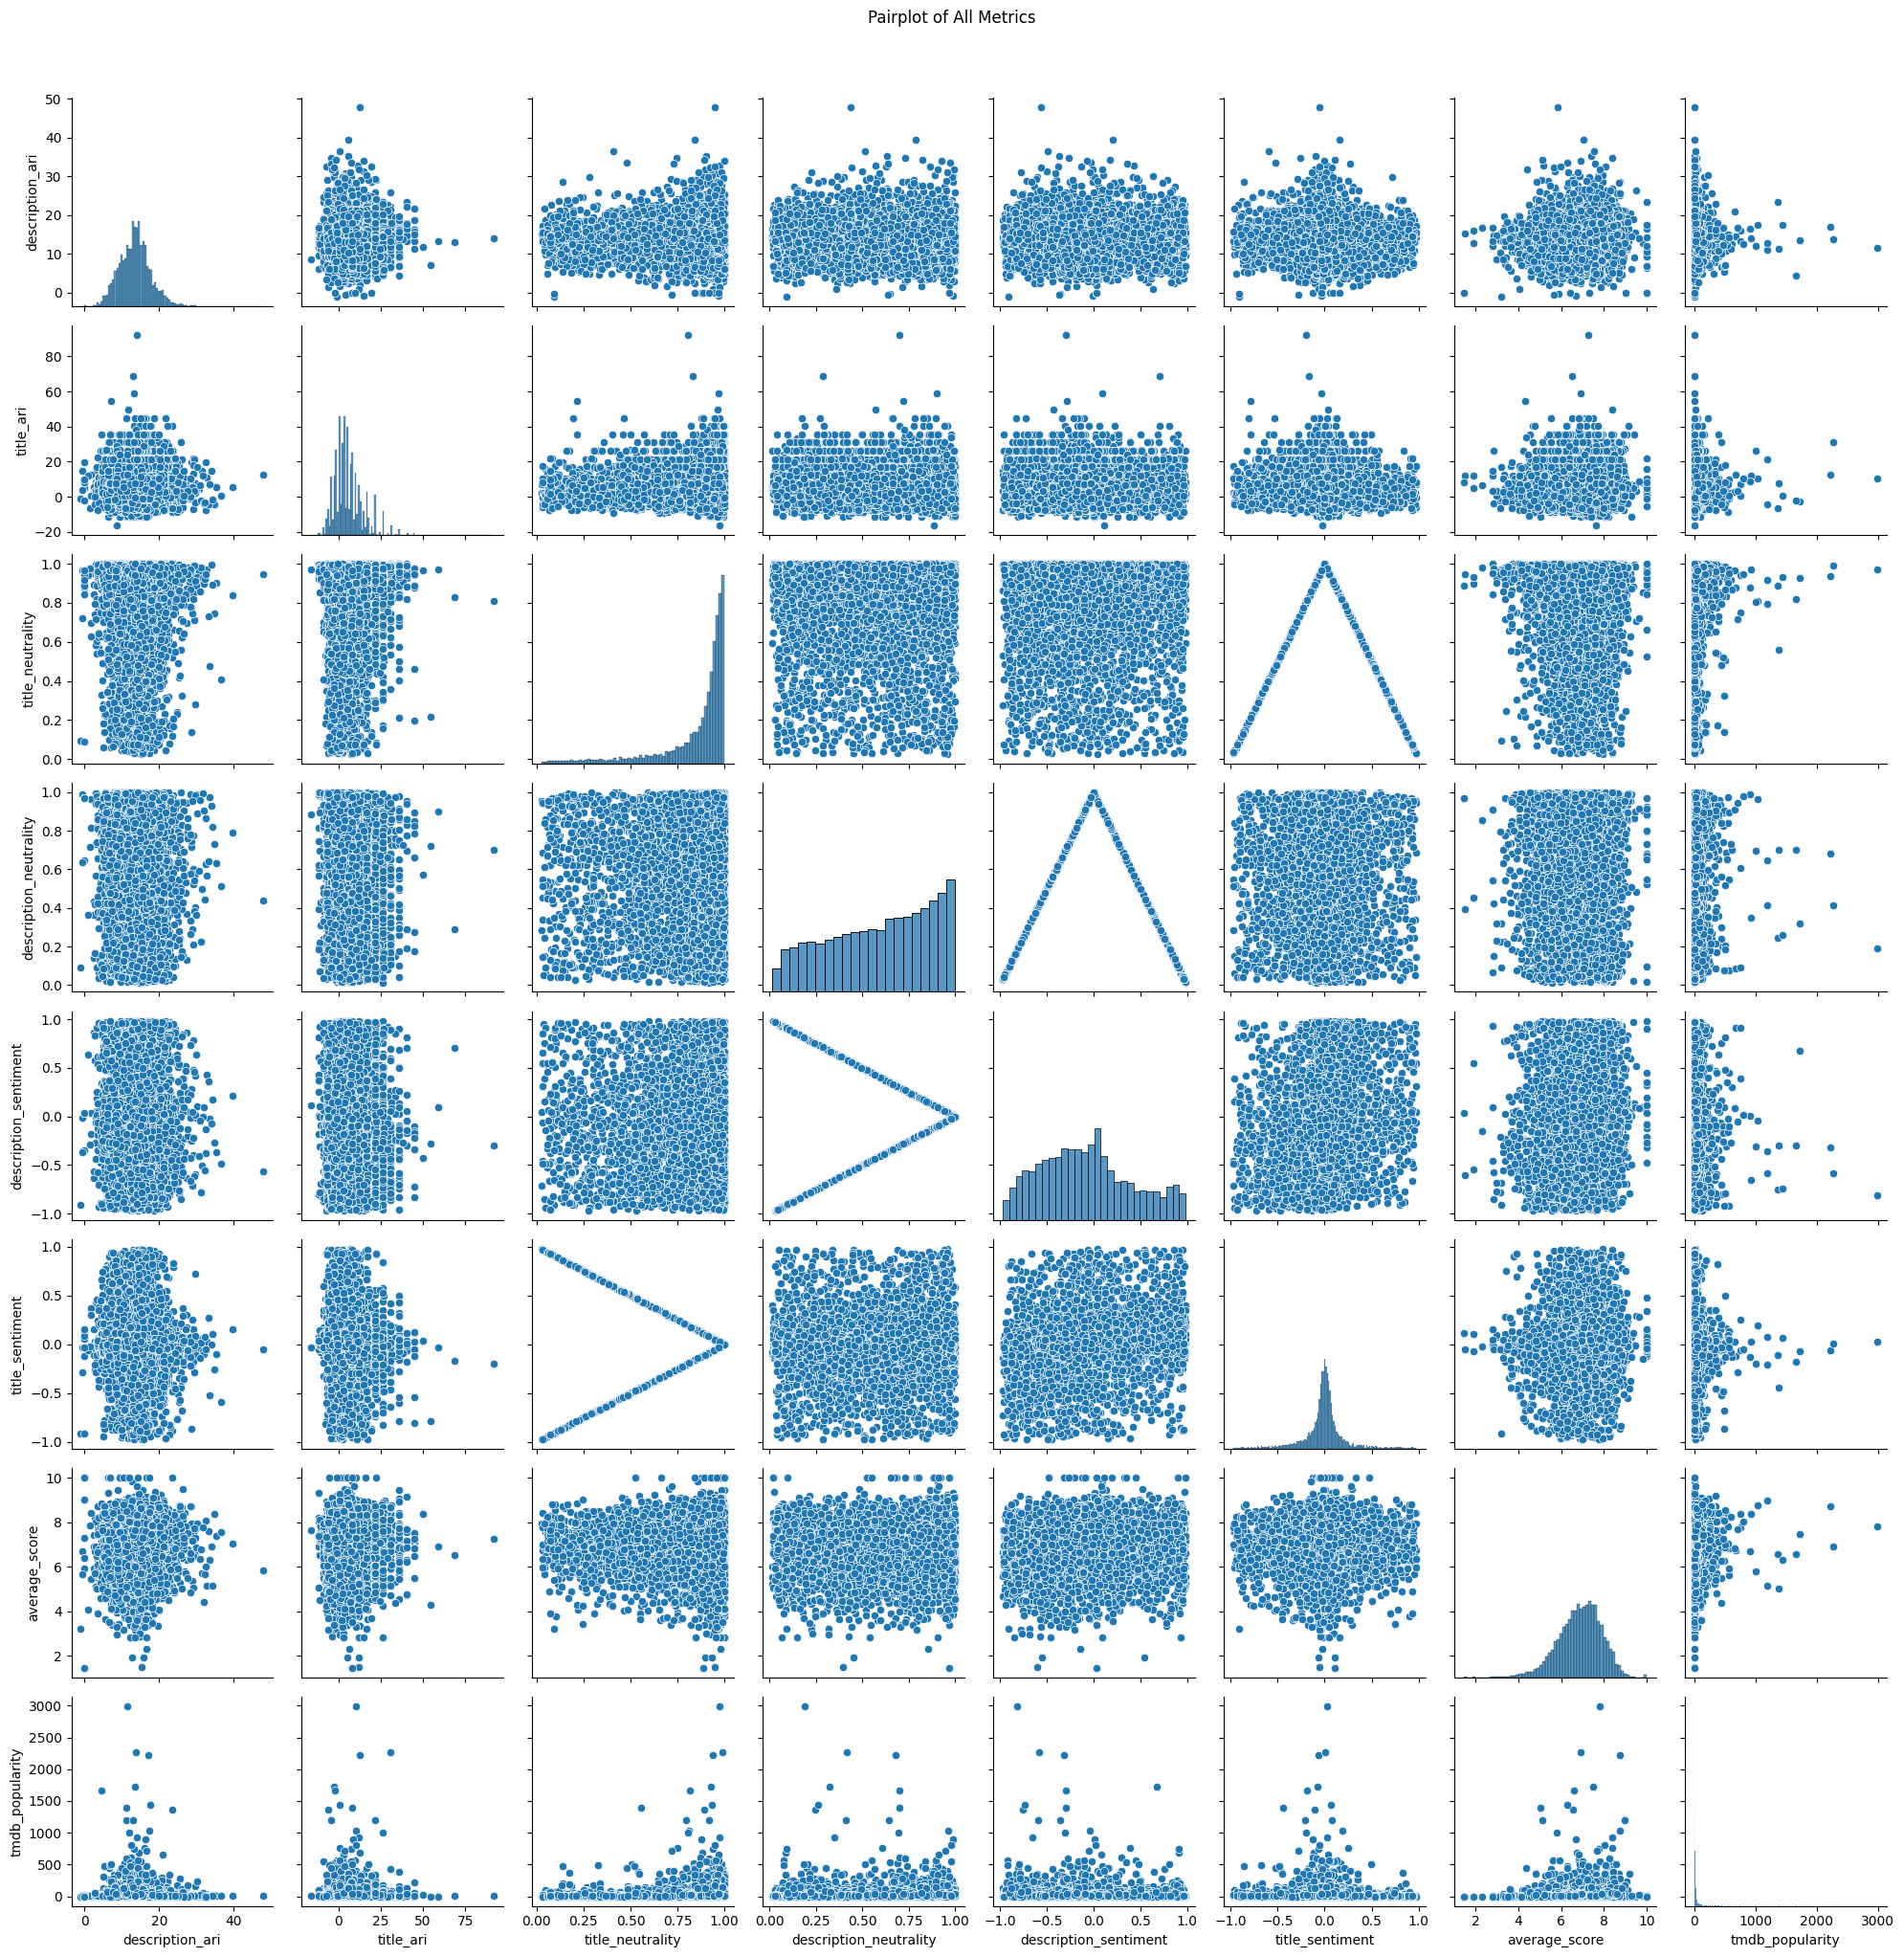

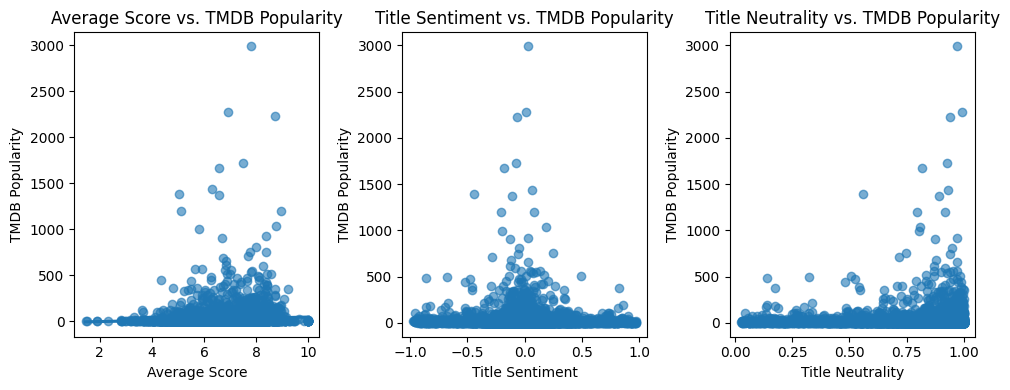

CPU times: user 17.3 s, sys: 254 ms, total: 17.6 s
Wall time: 17.5 s


In [ ]:
### Creating a heatmap of correlations and scatterplots for all pairs of variables of interest to get a better idea of relationships between variables.
%%time
import matplotlib.pyplot as plt
import seaborn as sns

# These are all the variables I want in the heatmap
numeric_cols = [
    'description_ari', 'title_ari',
    'title_neutrality', 'description_neutrality',
    'description_word_count', 'title_word_count',
    'description_character_count', 'title_character_count',
    'description_sentiment', 'title_sentiment',
    'average_score', 'tmdb_popularity'
]

# Creating a subset of the data with just the variables I want to look at
df_numeric = df[numeric_cols].dropna()

# Correlation Heatmap
plt.figure(figsize=(10, 6))
corr_matrix = df_numeric.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Text Metrics and Outcome Variables")
plt.tight_layout()
plt.show()

# Scatter Plots for every pair of variables
sns.pairplot(df_numeric)
plt.suptitle("Pairplot of All Metrics", y=1.02)
plt.tight_layout()
plt.show()

### Some other scatterplots I want a closer look at
# Organizing the plots into one simple figure grid
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

# Average Score vs. TMDB Popularity
sns.regplot(x='average_score', y='tmdb_popularity', data=df_numeric,
            scatter_kws={'alpha': 0.6}, ax=axes[0])
axes[0].set_title("Average Score vs. TMDB Popularity")
axes[0].set_xlabel("Average Score")
axes[0].set_ylabel("TMDB Popularity")

# Title Sentiment vs. TMDB Popularity
sns.regplot(x='title_sentiment', y='tmdb_popularity', data=df_numeric,
            scatter_kws={'alpha': 0.6}, ax=axes[1])
axes[1].set_title("Title Sentiment vs. TMDB Popularity")
axes[1].set_xlabel("Title Sentiment")
axes[1].set_ylabel("TMDB Popularity")

# Title Neutrality vs. TMDB Popularity
sns.regplot(x='title_neutrality', y='tmdb_popularity', data=df_numeric,
            scatter_kws={'alpha': 0.6}, ax=axes[2])
axes[2].set_title("Title Neutrality vs. TMDB Popularity")
axes[2].set_xlabel("Title Neutrality")
axes[2].set_ylabel("TMDB Popularity")

plt.tight_layout()
plt.show()

Multiple Threshold Analysis for TMDB Popularity vs. Title Neutrality

Threshold: 100
Number of shows in subset: 305
Threshold: 150
Number of shows in subset: 179
Threshold: 200
Number of shows in subset: 133
Threshold: 250
Number of shows in subset: 98
Threshold: 300
Number of shows in subset: 75
Threshold: 350
Number of shows in subset: 59
Threshold: 400
Number of shows in subset: 49
Threshold: 450
Number of shows in subset: 38
Threshold: 500
Number of shows in subset: 32
Threshold: 550
Number of shows in subset: 26
Threshold: 600
Number of shows in subset: 21
Threshold: 650
Number of shows in subset: 20
Threshold: 700
Number of shows in subset: 18
Threshold: 750
Number of shows in subset: 16
Threshold: 800
Number of shows in subset: 15
Threshold: 850
Number of shows in subset: 14
Threshold: 900
Number of shows in subset: 14
Threshold: 950
Number of shows in subset: 12
Threshold: 1000
Number of shows in subset: 11


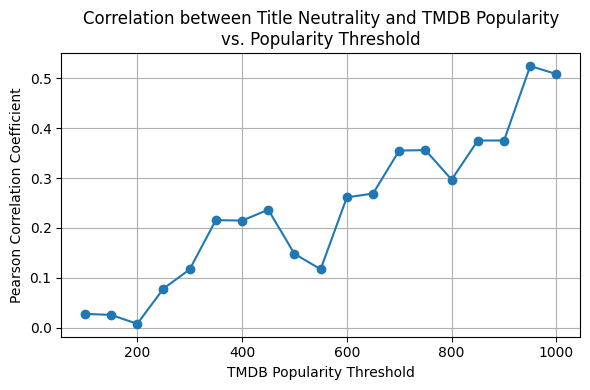

In [ ]:
# List to store the correlations that are assigned to each threshold
correlations = []

# All thresholds we want to look at
thresholds = [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]

for thresh in thresholds:
    # Removing shows/movies that do not meet the current popularity threshold
    df_filtered = df[df['tmdb_popularity'] >= thresh]

    # If this threshold yields us a subset of 10 or less observations, we can't make a meaningful conclusion
    if df_filtered.shape[0] <= 10:
        continue
    print(f"Threshold: {thresh}\nNumber of shows in subset: {df_filtered.shape[0]}")

    # Calculate correlation between title_neutrality and tmdb_popularity
    corr_val = df_filtered['title_neutrality'].corr(df_filtered['tmdb_popularity'])
    correlations.append((thresh, corr_val))

# Convert the correlation list into two lists for plotting the correlation vs. threshold
threshold_vals = [t for t, corr in correlations]
corr_vals = [corr for t, corr in correlations]

# Plot correlation as a function of the tmdb_popularity threshold
plt.figure(figsize=(6, 4))
plt.plot(threshold_vals, corr_vals, marker='o')
plt.title("Correlation between Title Neutrality and TMDB Popularity\nvs. Popularity Threshold")
plt.xlabel("TMDB Popularity Threshold")
plt.ylabel("Pearson Correlation Coefficient")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
%%time
# Picked a threshold that has meaning (600).
# Now I can run my query based on this threshold value.
# Columns for Text/Performance
cols = [
    'description_ari', 'title_ari',
    'title_neutrality', 'description_neutrality',
    'description_word_count', 'title_word_count',
    'description_character_count', 'title_character_count',
    'description_sentiment', 'title_sentiment',
    'average_score', 'tmdb_popularity'
]
# Filter the DataFrame for tmdb_popularity >= 600
# and select only the desired columns
final_subset = df[df['tmdb_popularity'] >= 600][cols]
print("Number of shows in subset:", final_subset.shape[0])

Number of shows in subset: 21
CPU times: user 2.14 ms, sys: 1.99 ms, total: 4.14 ms
Wall time: 8.61 ms


In [ ]:
%%time
# Define the columns to consider
cols = [
    'description_ari', 'title_ari',
    'title_neutrality', 'description_neutrality',
    'description_word_count', 'title_word_count',
    'description_character_count', 'title_character_count',
    'description_sentiment', 'title_sentiment',
    'average_score', 'tmdb_popularity'
]

# Filter the DataFrame for tmdb_popularity >= 600
# and select only the desired columns
final_subset = df[df['tmdb_popularity'] >= 600][cols]

print("Number of shows in subset:", final_subset.shape[0])
final_subset


Number of shows in subset: 21
CPU times: user 3.15 ms, sys: 971 µs, total: 4.12 ms
Wall time: 5.36 ms


description_ari  title_ari  title_neutrality  description_neutrality  \
448              11.5       10.2          0.971834                0.187877   
1164             16.1        0.5          0.748060                0.605118   
1948             11.1       -4.3          0.919264                0.645196   
1967             14.5       12.5          0.879736                0.086441   
1969             23.5       -6.4          0.889642                0.247020   
1976             12.5        2.6          0.870393                0.700072   
2940             17.4       10.2          0.810146                0.962287   
3201             17.0       12.5          0.937910                0.681404   
3212             14.1       12.0          0.971831                0.350258   
6553             11.2        7.8          0.557126                0.701392   
6556             17.5        0.6          0.932727                0.260275   
6558             13.3        7.3          0.939306                0.089094   
6559             12.0       26.2          0.805736                0.695029   
6562             13.6       -2.7          0.926659                0.321178   
6567             13.7       30.9          0.990512                0.413691   
6574              4.5       -1.9          0.817442                0.700965   
6579             16.4        8.8          0.875806                0.987990   
6605             20.9        2.8          0.968053                0.912163   
6903             12.9       21.5          0.794377                0.412339   
7026             16.7        3.6          0.716451                0.946332   
7647             12.6       10.2          0.948726                0.980434   

      description_word_count  title_word_count  description_character_count  \
448                       16                 2                           90   
1164                      53                 3                          303   
1948                     105                 3                          519   
1967                      84                 2                          442   
1969                      48                 2                          259   
1976                      52                 1                          270   
2940                      42                 2                          197   
3201                      26                 2                          149   
3212                      57                 1                          297   
6553                      26                 2                          148   
6556                      42                 4                          195   
6558                      26                 1                          142   
6559                      41                 1                          230   
6562                      31                 3                          153   
6567                      65                 1                          312   
6574                      33                 4                          143   
6579                      29                 6                          199   
6605                      40                 7                          223   
6903                      26                 1                          137   
7026                      27                 7                          156   
7647                      20                 3                          108   

      title_character_count  description_sentiment  title_sentiment  \
448                      14              -0.812123         0.028166   
1164                     15               0.394882         0.251940   
1948                     12              -0.354804         0.080736   
1967                     15               0.913559        -0.120264   
1969                      7              -0.752980        -0.110358   
1976                      5               0.299928        -0.129607   
2940                     14              -0.037713   

Multiple Threshold Analysis for 4 more relationships:

1) Title Word Count vs TMDB Popularity

2) Title Word Count vs Critic Score

3) Title Readability vs TMDB Popularity

4) Description Readability vs TMDB Popularity

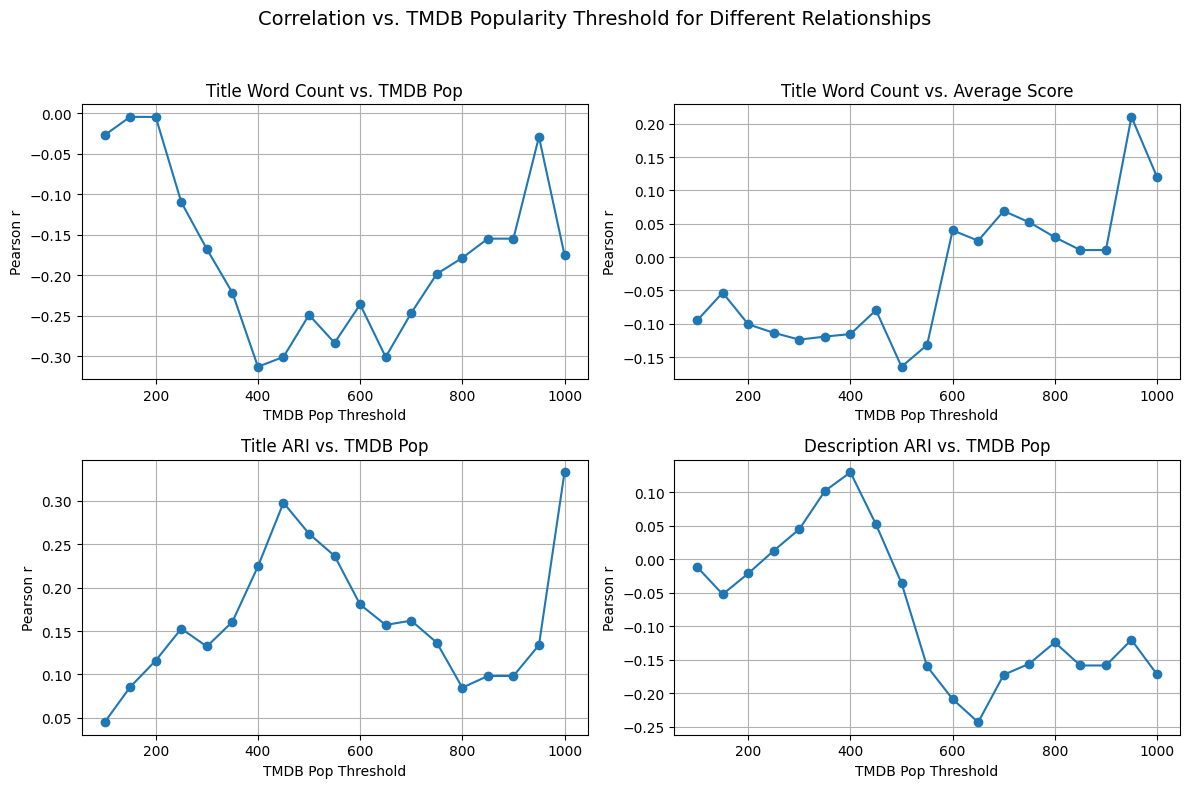

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

##### Multiple Threshold Analysis using TMDB Popularity as a cutoff

# We are creating a threshold to cut off "unpopular" shows from consideration because correlation calculations
# are being skewed towards zero due to the highly right skewed popularity distribution within this dataset.
# Creating subsets of the data and performing correlation calculations based on those different thresholded subsetes
# allows us to see if there is a general trend at any point, as well as if more popular shows have a greater tendency
# to be reflective in any way of their text metrics.

# Lists to store the correlations that are assigned to each threshold
title_word_tmdb_corr = []
title_word_avg_corr = []
title_ari_tmdb_corr = []
desc_ari_tmdb_corr = []

# All thresholds we want to look at
thresholds = [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]

# Threshold for how many samples are "too few" to effectively make any inference
min_samples = 10

### title_word_count vs. tmdb_popularity
for thresh in thresholds:
    df_filtered = df[df['tmdb_popularity'] >= thresh]
    if df_filtered.shape[0] < min_samples:
        continue
    corr_val = df_filtered['title_word_count'].corr(df_filtered['tmdb_popularity'])
    title_word_tmdb_corr.append((thresh, corr_val))

### title_word_count vs. average_score
for thresh in thresholds:
    df_filtered = df[df['tmdb_popularity'] >= thresh]
    if df_filtered.shape[0] < min_samples:
        continue
    corr_val = df_filtered['title_word_count'].corr(df_filtered['average_score'])
    title_word_avg_corr.append((thresh, corr_val))

### title_ari vs. tmdb_popularity
for thresh in thresholds:
    df_filtered = df[df['tmdb_popularity'] >= thresh]
    if df_filtered.shape[0] < min_samples:
        continue
    corr_val = df_filtered['title_ari'].corr(df_filtered['tmdb_popularity'])
    title_ari_tmdb_corr.append((thresh, corr_val))

### description_ari vs. tmdb_popularity
for thresh in thresholds:
    df_filtered = df[df['tmdb_popularity'] >= thresh]
    if df_filtered.shape[0] < min_samples:
        continue
    corr_val = df_filtered['description_ari'].corr(df_filtered['tmdb_popularity'])
    desc_ari_tmdb_corr.append((thresh, corr_val))

##### All plots: correlation vs. tmdb_popularity threshold for each relationship
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

### Title Word Count vs. TMDB Popularity
if title_word_tmdb_corr:
    thresh_vals, corr_vals = zip(*title_word_tmdb_corr)
    axes[0, 0].plot(thresh_vals, corr_vals, marker='o', linestyle='-')
    axes[0, 0].set_title("Title Word Count vs. TMDB Pop")
    axes[0, 0].set_xlabel("TMDB Pop Threshold")
    axes[0, 0].set_ylabel("Pearson r")
    axes[0, 0].grid(True)

### Title Word Count vs. Average Score
if title_word_avg_corr:
    thresh_vals, corr_vals = zip(*title_word_avg_corr)
    axes[0, 1].plot(thresh_vals, corr_vals, marker='o', linestyle='-')
    axes[0, 1].set_title("Title Word Count vs. Average Score")
    axes[0, 1].set_xlabel("TMDB Pop Threshold")
    axes[0, 1].set_ylabel("Pearson r")
    axes[0, 1].grid(True)

### Title ARI vs. TMDB Popularity
if title_ari_tmdb_corr:
    thresh_vals, corr_vals = zip(*title_ari_tmdb_corr)
    axes[1, 0].plot(thresh_vals, corr_vals, marker='o', linestyle='-')
    axes[1, 0].set_title("Title ARI vs. TMDB Pop")
    axes[1, 0].set_xlabel("TMDB Pop Threshold")
    axes[1, 0].set_ylabel("Pearson r")
    axes[1, 0].grid(True)

### Description ARI vs. TMDB Popularity
if desc_ari_tmdb_corr:
    thresh_vals, corr_vals = zip(*desc_ari_tmdb_corr)
    axes[1, 1].plot(thresh_vals, corr_vals, marker='o', linestyle='-')
    axes[1, 1].set_title("Description ARI vs. TMDB Pop")
    axes[1, 1].set_xlabel("TMDB Pop Threshold")
    axes[1, 1].set_ylabel("Pearson r")
    axes[1, 1].grid(True)

plt.suptitle("Correlation vs. TMDB Popularity Threshold for Different Relationships", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
df['imdb_votes'].describe()

count    7.219000e+03
mean     2.542700e+04
std      9.246318e+04
min      5.000000e+00
25%      6.125000e+02
50%      2.666000e+03
75%      1.238700e+04
max      2.294231e+06
Name: imdb_votes, dtype: float64

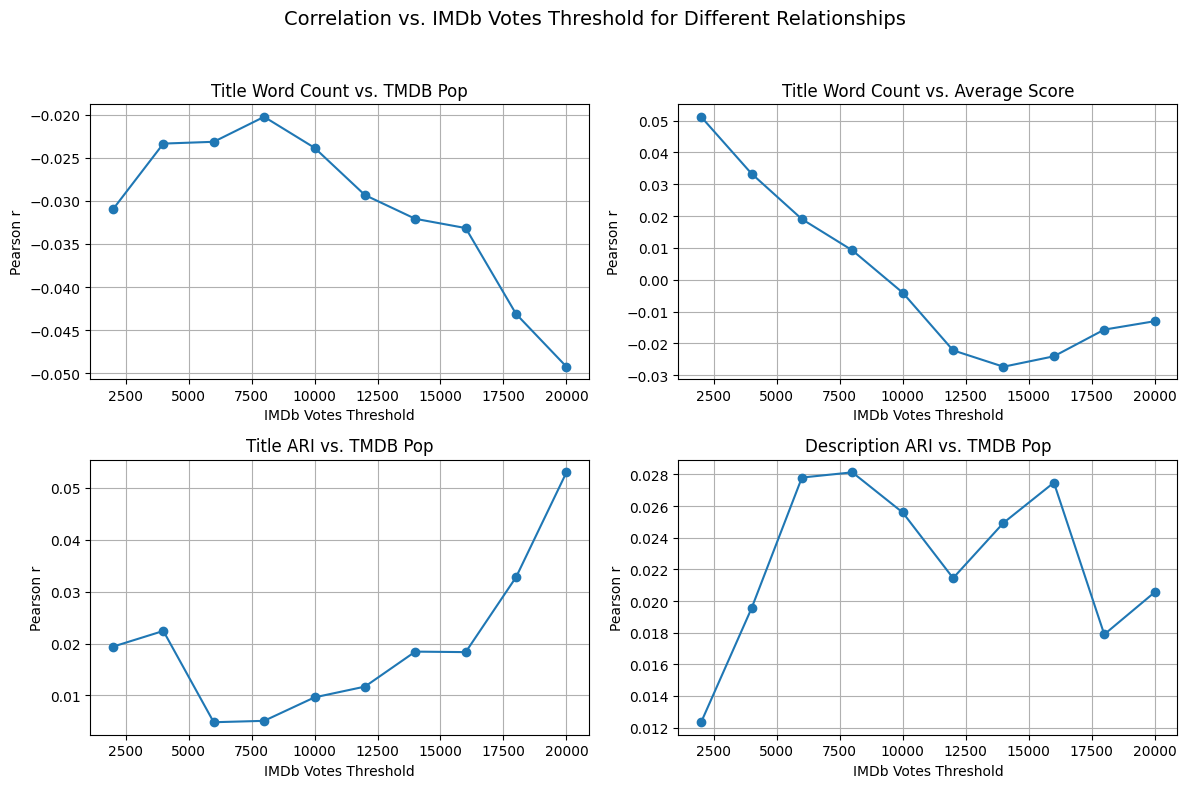

In [ ]:
##### Multiple Threshold Analysis using IMDB Votes as a cutoff

# Using IMDB Votes as a thresholding value did not seem to work better than using TMDB Popularity.
# In fact, it did the opposite. It is important to note that IMDB Votes are VERY highly right skewed.
# Additionally, considering that TMDB Popularity is calculated based on not only votes but several
# other metrics on TMDB's site (such as people adding to watchlist, favoriting, etc.), we are
# likely getting a more accurate measure of a movie/show's popularity from this metric.
# **Votes are not truly an effective measure of a show's popularity because the subset of viewers that votes on IMDB/TMDB can easily misrepresent the general audience**

##### For the sake of inference, we are disregarding the findings for any analysis that uses IMDB Votes as a thresholding value.

import matplotlib.pyplot as plt
import seaborn as sns

# All thresholds we want to look at (based on imdb_votes)
thresholds = [2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000, 20000]

# Lists to store the correlations that are assigned to each threshold
title_word_tmdb_corr = []
title_word_avg_corr = []
title_ari_tmdb_corr = []
desc_ari_tmdb_corr = []

# Threshold for how many samples are "too few" to effectively make any inference
min_samples = 10

### 1. title_word_count vs. tmdb_popularity
for thresh in thresholds:
    # Filter using imdb_votes as the threshold
    df_filtered = df[df['imdb_votes'] >= thresh]
    if df_filtered.shape[0] < min_samples:
        continue
    corr_val = df_filtered['title_word_count'].corr(df_filtered['tmdb_popularity'])
    title_word_tmdb_corr.append((thresh, corr_val))

### 2. title_word_count vs. average_score
for thresh in thresholds:
    df_filtered = df[df['imdb_votes'] >= thresh]
    if df_filtered.shape[0] < min_samples:
        continue
    corr_val = df_filtered['title_word_count'].corr(df_filtered['average_score'])
    title_word_avg_corr.append((thresh, corr_val))

### 3. title_ari vs. tmdb_popularity
for thresh in thresholds:
    df_filtered = df[df['imdb_votes'] >= thresh]
    if df_filtered.shape[0] < min_samples:
        continue
    corr_val = df_filtered['title_ari'].corr(df_filtered['tmdb_popularity'])
    title_ari_tmdb_corr.append((thresh, corr_val))

### 4. description_ari vs. tmdb_popularity
for thresh in thresholds:
    df_filtered = df[df['imdb_votes'] >= thresh]
    if df_filtered.shape[0] < min_samples:
        continue
    corr_val = df_filtered['description_ari'].corr(df_filtered['tmdb_popularity'])
    desc_ari_tmdb_corr.append((thresh, corr_val))

##### All summary plots: correlation vs. imdb_votes threshold for each relationship
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

### Title Word Count vs. TMDB Popularity
if title_word_tmdb_corr:
    thresh_vals, corr_vals = zip(*title_word_tmdb_corr)
    axes[0, 0].plot(thresh_vals, corr_vals, marker='o', linestyle='-')
    axes[0, 0].set_title("Title Word Count vs. TMDB Pop")
    axes[0, 0].set_xlabel("IMDb Votes Threshold")
    axes[0, 0].set_ylabel("Pearson r")
    axes[0, 0].grid(True)

### Title Word Count vs. Average Score
if title_word_avg_corr:
    thresh_vals, corr_vals = zip(*title_word_avg_corr)
    axes[0, 1].plot(thresh_vals, corr_vals, marker='o', linestyle='-')
    axes[0, 1].set_title("Title Word Count vs. Average Score")
    axes[0, 1].set_xlabel("IMDb Votes Threshold")
    axes[0, 1].set_ylabel("Pearson r")
    axes[0, 1].grid(True)

### Title ARI vs. TMDB Popularity
if title_ari_tmdb_corr:
    thresh_vals, corr_vals = zip(*title_ari_tmdb_corr)
    axes[1, 0].plot(thresh_vals, corr_vals, marker='o', linestyle='-')
    axes[1, 0].set_title("Title ARI vs. TMDB Pop")
    axes[1, 0].set_xlabel("IMDb Votes Threshold")
    axes[1, 0].set_ylabel("Pearson r")
    axes[1, 0].grid(True)

### Description ARI vs. TMDB Popularity
if desc_ari_tmdb_corr:
    thresh_vals, corr_vals = zip(*desc_ari_tmdb_corr)
    axes[1, 1].plot(thresh_vals, corr_vals, marker='o', linestyle='-')
    axes[1, 1].set_title("Description ARI vs. TMDB Pop")
    axes[1, 1].set_xlabel("IMDb Votes Threshold")
    axes[1, 1].set_ylabel("Pearson r")
    axes[1, 1].grid(True)

plt.suptitle("Correlation vs. IMDb Votes Threshold for Different Relationships", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Principal Component Analysis and t-SNE Clustering for various text metric features

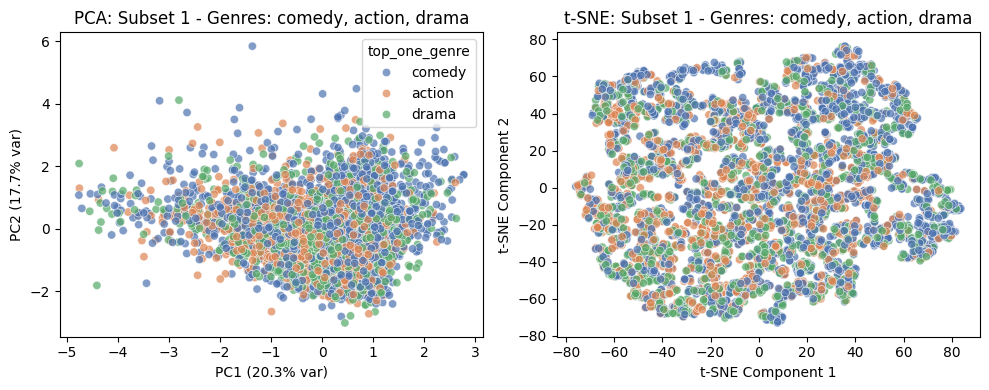

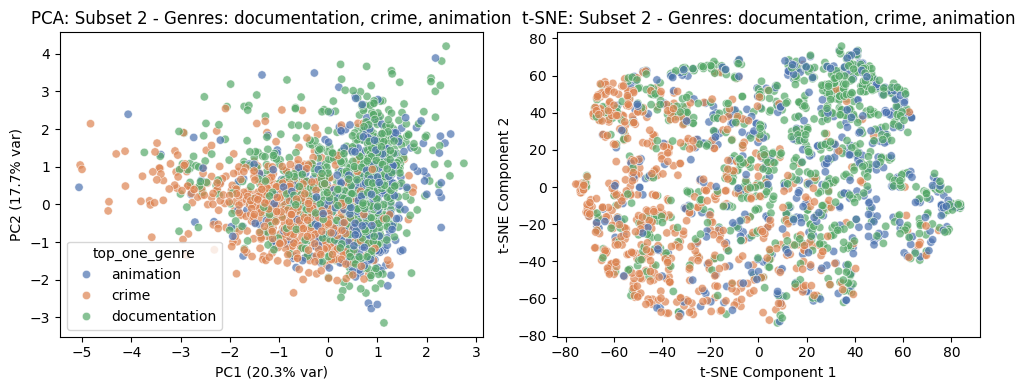

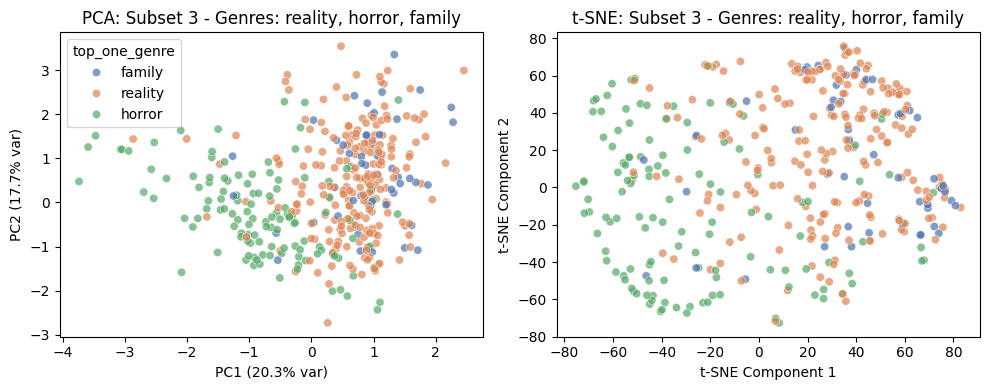

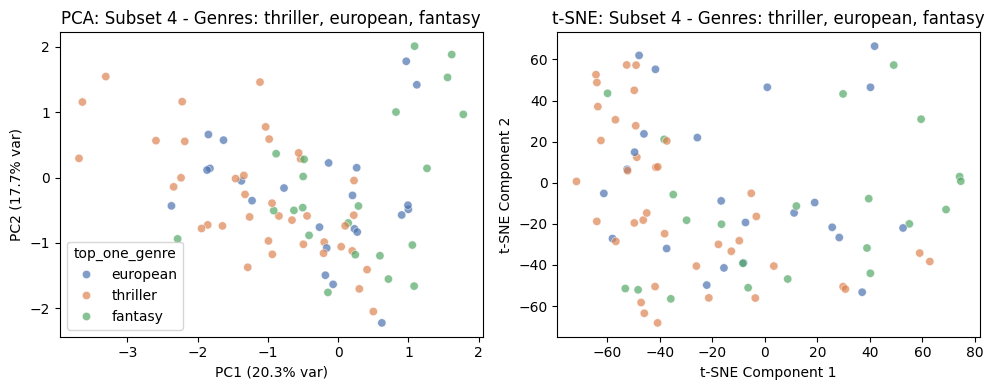

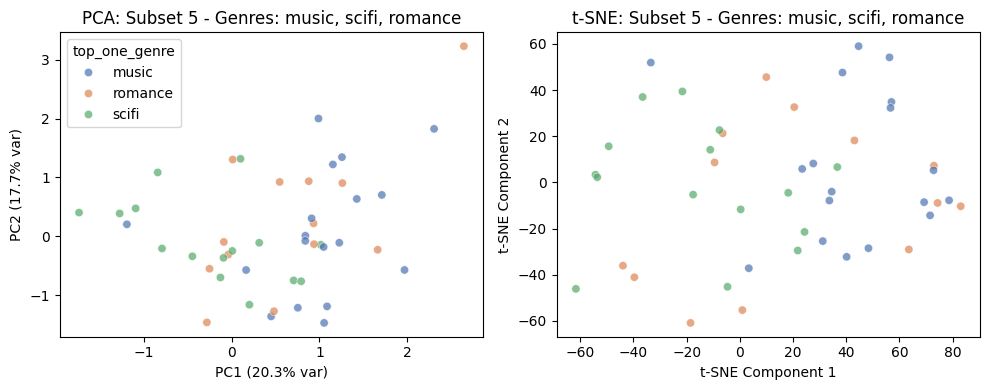

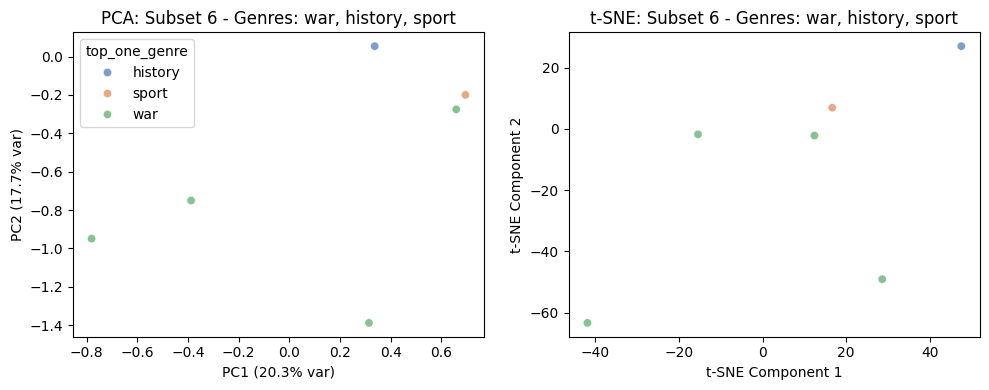

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Metrics to analyze
features = [
    'description_sentiment', 'title_sentiment',
    'description_neutrality', 'title_neutrality',
    'description_ari', 'title_ari',
    # I've excluded the word and character counts of titles/descriptions for this analysis
    # I did this because I want to focus on metrics that are not obvious at first glance, such as how long a title is
    # Additionally, word and character counts are highly correlated to each other, which may confound our t-SNE inferences
]

# Dropping empty genres and standardizing data
data = df[features + ['top_one_genre']].dropna()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[features])

# ----- PCA -----
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
explained_variance = pca.explained_variance_ratio_
pc1_label = f"PC1 ({explained_variance[0]*100:.1f}% var)"
pc2_label = f"PC2 ({explained_variance[1]*100:.1f}% var)"
data['pca1'] = data_pca[:, 0]
data['pca2'] = data_pca[:, 1]

# ----- t-SNE -----
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(data_scaled)
data['tsne1'] = data_tsne[:, 0]
data['tsne2'] = data_tsne[:, 1]

# Get the top 18 most frequent genres from top_one_genre and reorganize them into six subsets (3 per group)
genre_counts = data['top_one_genre'].value_counts()
top_genres = list(genre_counts.head(18).index)

# Take a subset of the data that only includes these top 18 genres
data_top = data[data['top_one_genre'].isin(top_genres)]

# Split into six further subsets
genre_groups = [top_genres[i:i+3] for i in range(0, len(top_genres), 3)]

# PCA and t-SNE plots
for idx, group in enumerate(genre_groups):
    subset_data = data_top[data_top['top_one_genre'].isin(group)]
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # PCA plot
    sns.scatterplot(data=subset_data, x='pca1', y='pca2', hue='top_one_genre',
                    palette="deep", alpha=0.7, ax=axes[0])
    axes[0].set_title(f"PCA: Subset {idx+1} - Genres: {', '.join(group)}")
    axes[0].set_xlabel(pc1_label)
    axes[0].set_ylabel(pc2_label)

    # t-SNE plot
    sns.scatterplot(data=subset_data, x='tsne1', y='tsne2', hue='top_one_genre',
                    palette="deep", alpha=0.7, ax=axes[1])
    axes[1].set_title(f"t-SNE: Subset {idx+1} - Genres: {', '.join(group)}")
    axes[1].set_xlabel("t-SNE Component 1")
    axes[1].set_ylabel("t-SNE Component 2")

    # Cleaner plot legend
    axes[1].legend_.remove() if axes[1].get_legend() is not None else None

    plt.tight_layout()
    plt.show()


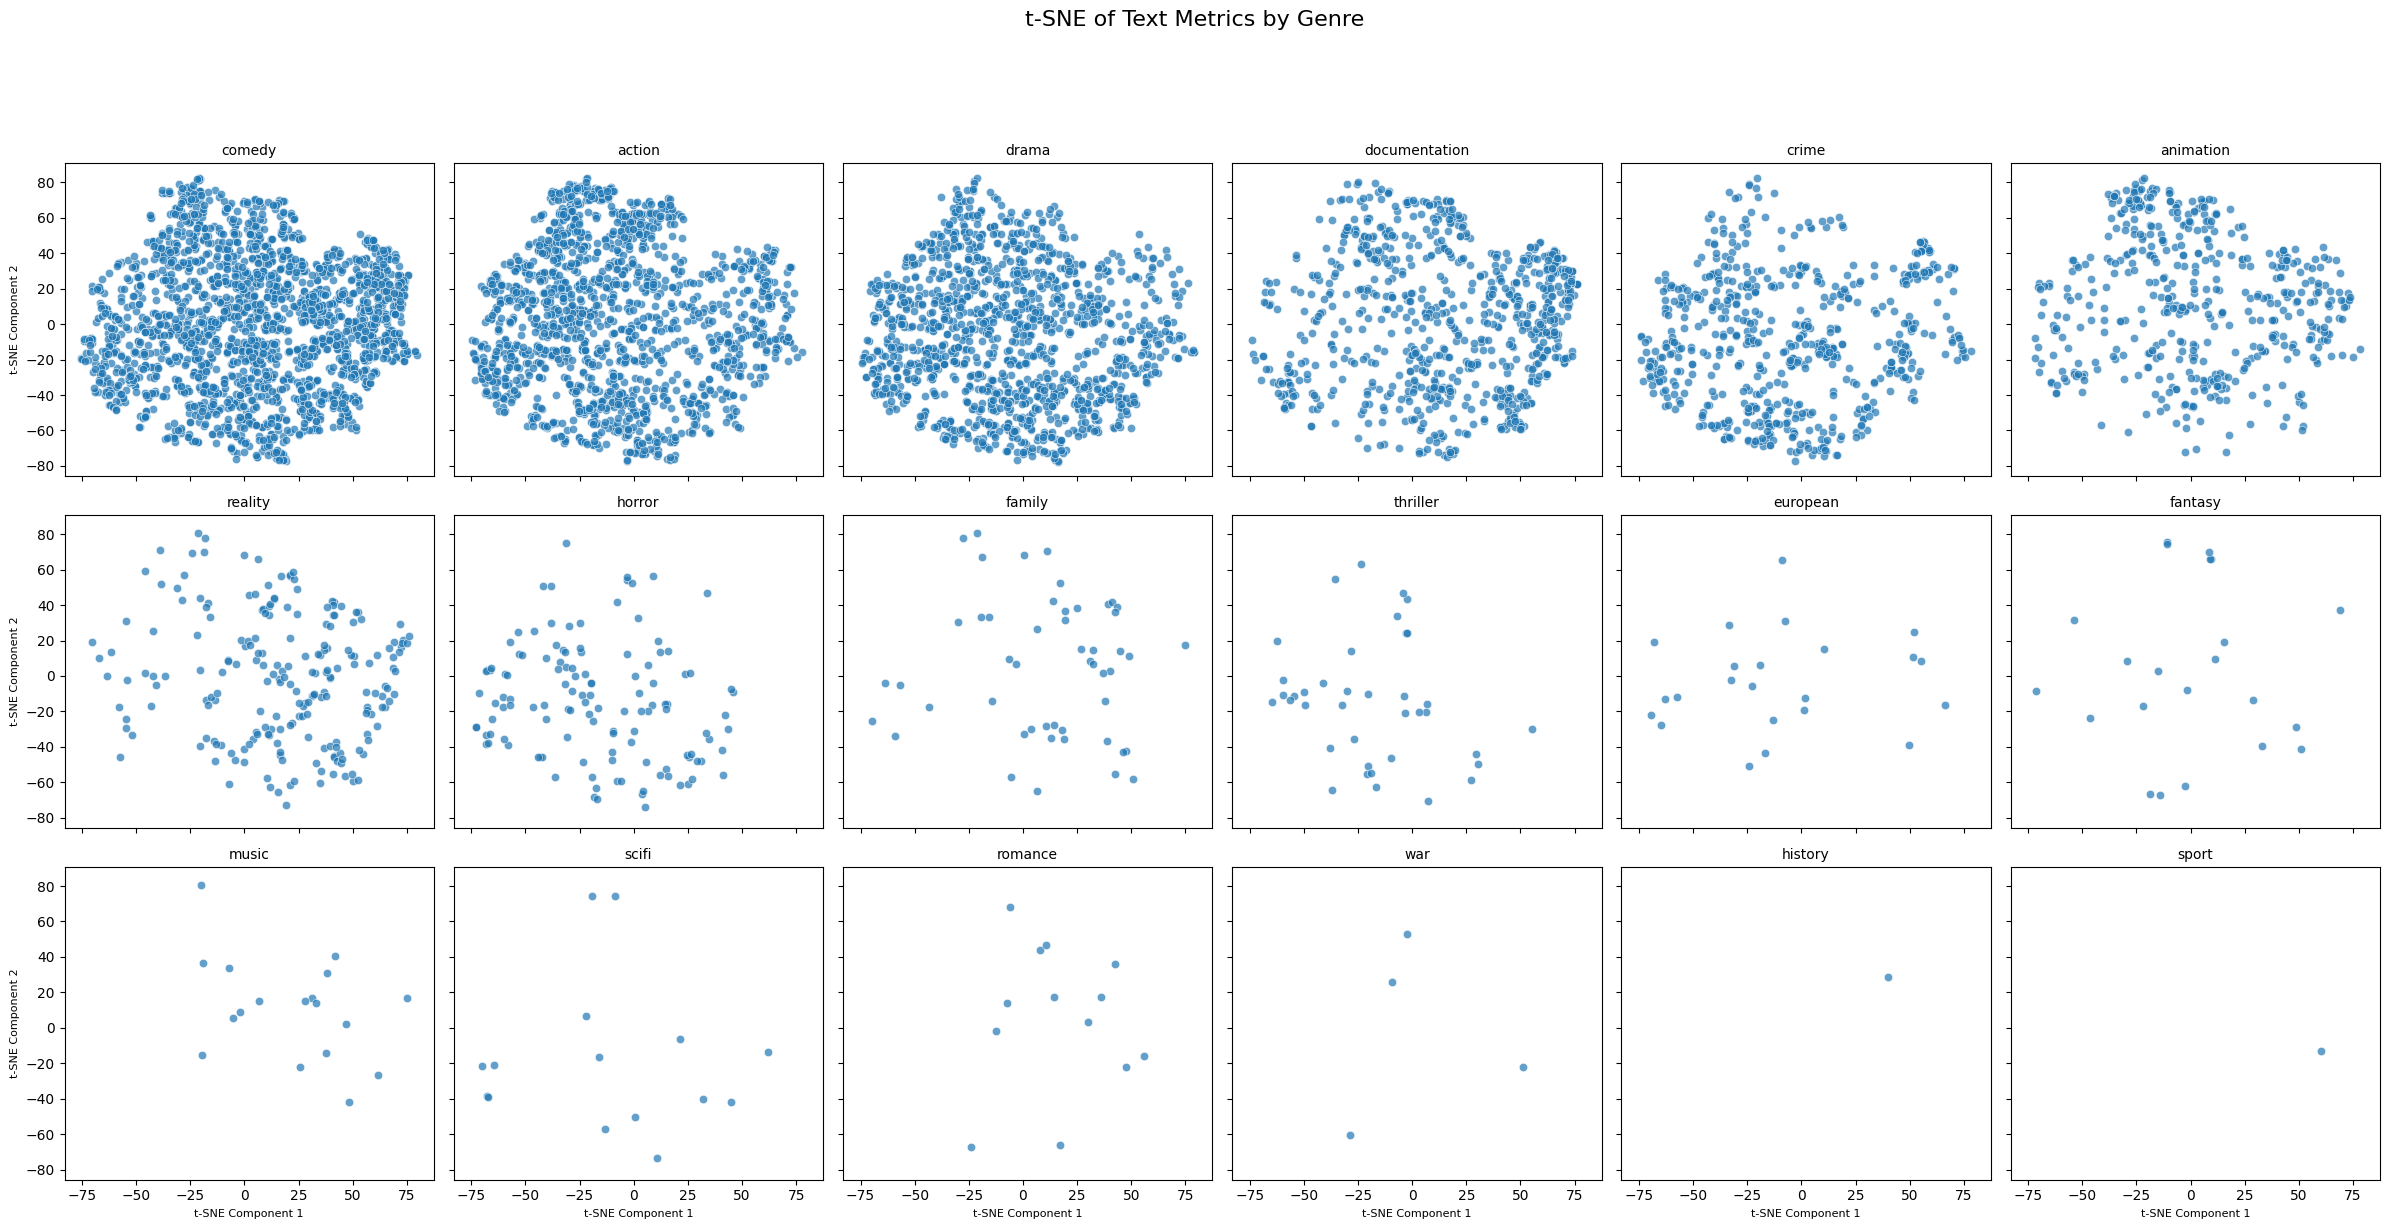

In [ ]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Included attributes
features = [
    'description_sentiment', 'title_sentiment',
    'description_ari', 'title_ari',
    'description_word_count', 'title_word_count',
    'description_character_count', 'title_character_count'
]

# Filter columns with 'top_one_genre'
filtered_data = df.dropna(subset=features + ['top_one_genre']).copy()

# Get the top 18 genres
genre_counts = filtered_data['top_one_genre'].value_counts()
top_genres = list(genre_counts.index)
if len(top_genres) > 18:
    top_genres = top_genres[:18]
filtered_data = filtered_data[filtered_data['top_one_genre'].isin(top_genres)]

# Standardize data to prep for clustering
scaler = StandardScaler()
data_scaled = scaler.fit_transform(filtered_data[features])

# Apply t-SNE to reduce dimensions
tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(data_scaled)
filtered_data['tsne1'] = tsne_components[:, 0]
filtered_data['tsne2'] = tsne_components[:, 1]

n_genres = len(top_genres)
n_cols = 6
n_rows = math.ceil(n_genres / n_cols)

# Visualize
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), sharex=True, sharey=True)
axes = axes.flatten()

# One t-SNE plot per genre
for i, genre in enumerate(top_genres):
    genre_data = filtered_data[filtered_data['top_one_genre'] == genre]
    sns.scatterplot(data=genre_data, x='tsne1', y='tsne2', ax=axes[i], alpha=0.7)
    axes[i].set_title(genre, fontsize=10)
    axes[i].set_xlabel("t-SNE Component 1", fontsize=8)
    axes[i].set_ylabel("t-SNE Component 2", fontsize=8)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("t-SNE of Text Metrics by Genre", fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
##### Let's do some analysis into how likely there is a pattern within each genre based on the t-SNE clustering.

# I've created a "pattern metric" that calculates how far the centroid of a certain genre's clustering is from the
# trivial center, [0,0]. This yields us an interval attribute we can use to compare the "pattern-ness" of genres
# based on their text metrics.

import numpy as np
from scipy.stats import skew

def compute_pattern_metric(df, x_col='tsne1', y_col='tsne2', genre_col='top_one_genre', min_points=50):
    pattern_metrics = {}
    genres = df[genre_col].unique()
    for genre in genres:
        # Pull a single genre (current genre)
        genre_data = df[df[genre_col].str.lower() == genre.lower()]
        if len(genre_data) < min_points:
            continue

        # Compute centroid of the cluster based on the t-SNE dimensions
        centroid_x = np.mean(genre_data[x_col])
        centroid_y = np.mean(genre_data[y_col])
        centroid_displacement = np.sqrt(centroid_x**2 + centroid_y**2)

        # Compute asymmetry about the x-axis
        mean_x = np.mean(genre_data[x_col])
        median_x = np.median(genre_data[x_col])
        asymmetry = abs(mean_x - median_x)

        # Calculate our final pattern metric (weighted sum of displacement and asymmetry)
        # I've weighted centroid displacement more because a global shift in data is likely more significant
        # in telling a pattern for text metrics during clustering than asymmetric data is
        pattern_metric = centroid_displacement * 0.65 + asymmetry * 0.35

        pattern_metrics[genre] = {
            'n_points': len(genre_data),
            'centroid_displacement': centroid_displacement,
            'asymmetry_tsne1': asymmetry,
            'pattern_metric': pattern_metric
        }
    return pattern_metrics

pattern_metrics = compute_pattern_metric(filtered_data)

# Print values
print("Pattern Metric for each genre (higher means more shifted from center and asymmetric):\n")
for genre, metrics in pattern_metrics.items():
    print(f"Genre: {genre}")
    print(f"  Number of points: {metrics['n_points']}")
    print(f"  Centroid displacement from (0,0): {metrics['centroid_displacement']:.3f}")
    print(f"  Asymmetry (|mean - median| on tsne1): {metrics['asymmetry_tsne1']:.3f}")
    print(f"  Composite Pattern Metric: {metrics['pattern_metric']:.3f}\n")

# Mean for pattern metric values
mean_pattern_metric = np.mean([metrics['pattern_metric'] for metrics in pattern_metrics.values()])
print(f"Mean Pattern Metric across all genres: {mean_pattern_metric:.3f}")

Pattern Metric for each genre (higher means more shifted from center and asymmetric):

Genre: comedy
  Number of points: 2240
  Centroid displacement from (0,0): 6.487
  Asymmetry (|mean - median| on tsne1): 0.613
  Composite Pattern Metric: 4.431

Genre: animation
  Number of points: 483
  Centroid displacement from (0,0): 14.246
  Asymmetry (|mean - median| on tsne1): 2.096
  Composite Pattern Metric: 9.993

Genre: family
  Number of points: 50
  Centroid displacement from (0,0): 12.081
  Asymmetry (|mean - median| on tsne1): 4.807
  Composite Pattern Metric: 9.535

Genre: crime
  Number of points: 642
  Centroid displacement from (0,0): 10.353
  Asymmetry (|mean - median| on tsne1): 2.774
  Composite Pattern Metric: 7.700

Genre: action
  Number of points: 1605
  Centroid displacement from (0,0): 9.861
  Asymmetry (|mean - median| on tsne1): 3.711
  Composite Pattern Metric: 7.709

Genre: drama
  Number of points: 1381
  Centroid displacement from (0,0): 9.713
  Asymmetry (|mean - m

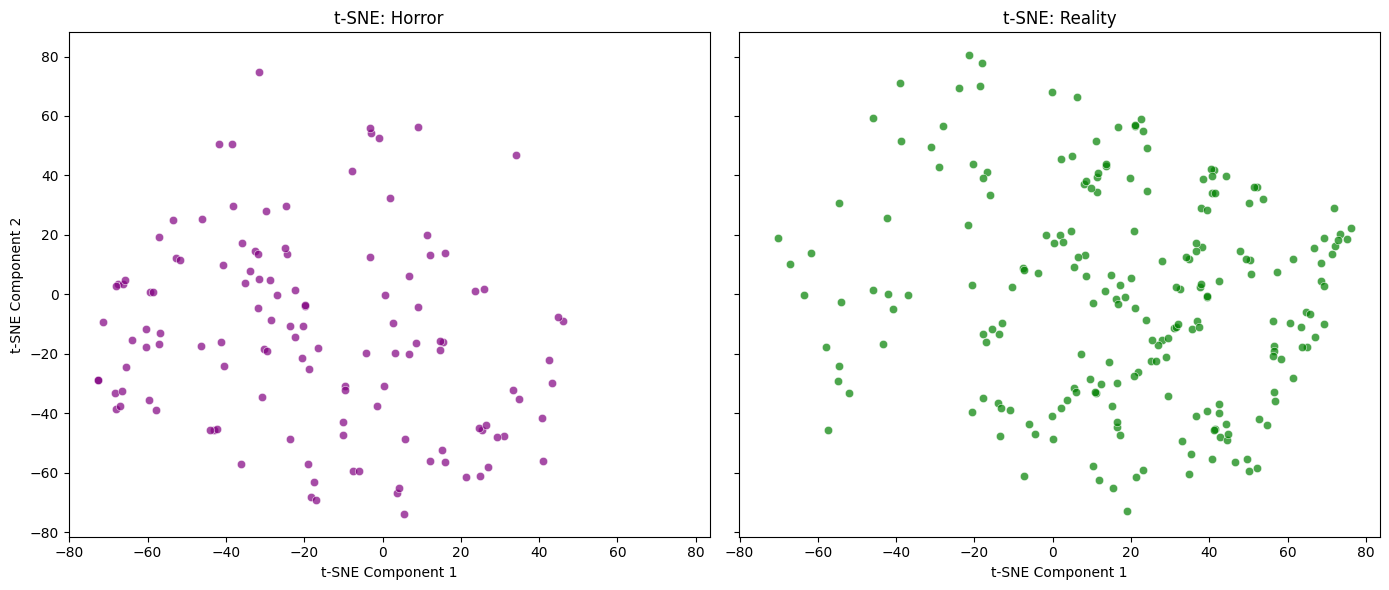

In [ ]:
##### Getting plots for specifically Horror and Reality, since they yielded the highest pattern values.
horror_data = filtered_data[filtered_data['top_one_genre'].str.lower() == 'horror']
reality_data = filtered_data[filtered_data['top_one_genre'].str.lower() == 'reality']

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Plot for Horror
sns.scatterplot(data=horror_data, x='tsne1', y='tsne2', ax=axes[0], alpha=0.7, color='purple')
axes[0].set_title("t-SNE: Horror")
axes[0].set_xlabel("t-SNE Component 1")
axes[0].set_ylabel("t-SNE Component 2")

# Plot for Reality
sns.scatterplot(data=reality_data, x='tsne1', y='tsne2', ax=axes[1], alpha=0.7, color='green')
axes[1].set_title("t-SNE: Reality")
axes[1].set_xlabel("t-SNE Component 1")
axes[1].set_ylabel("t-SNE Component 2")

plt.tight_layout()
plt.show()
